In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import scorecard_function


def DelqFeatures(event,window,type):
    current = 12
    start = 12 - window + 1
    delq1 = [event[a] for a in ['Delq1_' + str(t) for t in range(current, start - 1, -1)]]
    delq2 = [event[a] for a in ['Delq2_' + str(t) for t in range(current, start - 1, -1)]]
    delq3 = [event[a] for a in ['Delq3_' + str(t) for t in range(current, start - 1, -1)]]
    if type == 'max delq':
        if max(delq3) == 1:
            return 3
        elif max(delq2) == 1:
            return 2
        elif max(delq1) == 1:
            return 1
        else:
            return 0
    if type in ['M0 times','M1 times', 'M2 times']:
        if type.find('M0')>-1:
            return sum(delq1)
        elif type.find('M1')>-1:
            return sum(delq2)
        else:
            return sum(delq3)

def UrateFeatures(event, window, type):
    current = 12
    start = 12 - window + 1
    monthlySpend = [event[a] for a in ['Spend_' + str(t) for t in range(current, start - 1, -1)]]
    limit = event['Loan_Amount']
    monthlyUrate = [x / limit for x in monthlySpend]
    if type == 'mean utilization rate':
        return np.mean(monthlyUrate)
    if type == 'max utilization rate':
        return max(monthlyUrate)
    if type == 'increase utilization rate':
        currentUrate = monthlyUrate[0:-1]
        previousUrate = monthlyUrate[1:]
        compareUrate = [int(x[0]>x[1]) for x in zip(currentUrate,previousUrate)]
        return sum(compareUrate)

def PaymentFeatures(event, window, type):
    current = 12
    start = 12 - window + 1
    currentPayment = [event[a] for a in ['Payment_' + str(t) for t in range(current, start - 1, -1)]]
    previousOS = [event[a] for a in ['OS_' + str(t) for t in range(current-1, start - 2, -1)]]
    monthlyPayRatio = []
    for Pay_OS in zip(currentPayment,previousOS):
        if Pay_OS[1]>0:
            payRatio = Pay_OS[0]*1.0 / Pay_OS[1]
            monthlyPayRatio.append(payRatio)
        else:
            monthlyPayRatio.append(1)
    if type == 'min payment ratio':
        return min(monthlyPayRatio)
    if type == 'max payment ratio':
        return max(monthlyPayRatio)
    if type == 'mean payment ratio':
        total_payment = sum(currentPayment)
        total_OS = sum(previousOS)
        if total_OS > 0:
            return total_payment / total_OS
        else:
            return 1

#################################
#   1, 读取数据，衍生初始变量   #
#################################
#folderOfData = r'F:\py\program\行为评分卡'

#trainData = pd.read_csv(folderOfData+'\trainData.csv',header = 0)
#testData = pd.read_csv(folderOfData+'\testData.csv',header = 0)
trainData = pd.read_csv('trainData.csv',header = 0)
testData = pd.read_csv('testData.csv',header = 0)

allFeatures = []
'''
逾期类型的特征在行为评分卡（预测违约行为）中，一般是非常显著的变量。
通过设定时间窗口，可以衍生以下类型的逾期变量：
'''
# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 1，过去t时间窗口内的最大逾期状态
    allFeatures.append('maxDelqL'+str(t)+"M")
    trainData['maxDelqL'+str(t)+"M"] = trainData.apply(lambda x: DelqFeatures(x,t,'max delq'),axis=1)

    # 2，过去t时间窗口内的，M0,M1,M2的次数
    allFeatures.append('M0FreqL' + str(t) + "M")
    trainData['M0FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x,t,'M0 times'),axis=1)

    allFeatures.append('M1FreqL' + str(t) + "M")
    trainData['M1FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x, t, 'M1 times'), axis=1)

    allFeatures.append('M2FreqL' + str(t) + "M")
    trainData['M2FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x, t, 'M2 times'), axis=1)



'''
额度使用率类型特征在行为评分卡模型中，通常是与违约高度相关的
'''
# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 1，过去t时间窗口内的最大月额度使用率
    allFeatures.append('maxUrateL' + str(t) + "M")
    trainData['maxUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x,t,'max utilization rate'),axis = 1)

    # 2，过去t时间窗口内的平均月额度使用率
    allFeatures.append('avgUrateL' + str(t) + "M")
    trainData['avgUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x, t, 'mean utilization rate'),
                                                            axis=1)

    # 3，过去t时间窗口内，月额度使用率增加的月份。该变量要求t>1
    if t > 1:
        allFeatures.append('increaseUrateL' + str(t) + "M")
        trainData['increaseUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x, t, 'increase utilization rate'),
                                                                axis=1)

'''
还款类型特征也是行为评分卡模型中常用的特征
'''
# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 1，过去t时间窗口内的最大月还款率
    allFeatures.append('maxPayL' + str(t) + "M")
    trainData['maxPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'max payment ratio'),
                                                            axis=1)

    # 2，过去t时间窗口内的最小月还款率
    allFeatures.append('minPayL' + str(t) + "M")
    trainData['minPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'min payment ratio'),
                                                          axis=1)

    # 3，过去t时间窗口内的平均月还款率
    allFeatures.append('avgPayL' + str(t) + "M")
    trainData['avgPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'mean payment ratio'),
                                                          axis=1)


'''
类别型变量：过去t时间内最大的逾期状态
需要检查与bad的相关度
'''
print(trainData.groupby(['maxDelqL1M'])['label'].mean())
print(trainData.groupby(['maxDelqL3M'])['label'].mean())
print(trainData.groupby(['maxDelqL6M'])['label'].mean())
print(trainData.groupby(['maxDelqL12M'])['label'].mean())







maxDelqL1M
0    0.102087
1    0.109065
2    0.514403
3    0.956710
Name: label, dtype: float64
maxDelqL3M
0    0.047477
1    0.050318
2    0.434509
3    0.958009
Name: label, dtype: float64
maxDelqL6M
0    0.047886
1    0.050380
2    0.265044
3    0.549407
Name: label, dtype: float64
maxDelqL12M
0    0.070175
1    0.044748
2    0.182365
3    0.380687
Name: label, dtype: float64


In [2]:
############################
#   2, 分箱，计算WOE并编码   #
############################
'''
对类别型变量的分箱和WOE计算
可以通过计算取值个数的方式判断是否是类别型变量
'''
categoricalFeatures = []
numericalFeatures = []
WOE_IV_dict = {}
for var in allFeatures:
    if len(set(trainData[var])) > 5:
        numericalFeatures.append(var)
    else:
        categoricalFeatures.append(var)
not_monotone =[]
for var in categoricalFeatures:
    #检查bad rate在箱中的单调性
    if not scorecard_function.BadRateMonotone(trainData, var, 'label'):
        not_monotone.append(var)
print(not_monotone)

['M1FreqL3M', 'M2FreqL3M', 'maxDelqL12M']


In [3]:
trainData.groupby(['M2FreqL3M'])['label'].count()   #其中，M2FreqL3M＝3总共只有3个样本，因此要进行合并

M2FreqL3M
0    27456
1      585
2       55
3        3
Name: label, dtype: int64

In [4]:
# 将 M2FreqL3M>=1的合并为一组，计算WOE和IV
trainData['M2FreqL3M_Bin'] = trainData['M2FreqL3M'].apply(lambda x: int(x>=1))
trainData.groupby(['M2FreqL3M_Bin'])['label'].mean()
WOE_IV_dict['M2FreqL3M_Bin'] = scorecard_function.CalcWOE(trainData, 'M2FreqL3M_Bin', 'label')

#检查M1FreqL3M单调性
print(trainData.groupby(['M1FreqL3M'])['label'].mean())  
print(trainData.groupby(['M1FreqL3M'])['label'].count())

M1FreqL3M
0    0.049511
1    0.409583
2    0.930825
3    0.927083
Name: label, dtype: float64
M1FreqL3M
0    22379
1     4800
2      824
3       96
Name: label, dtype: int64


In [6]:
trainData['M1FreqL3M_Bin'] = trainData['M1FreqL3M'].apply(lambda x: int(x>=1))
trainData.groupby(['M1FreqL3M_Bin'])['label'].mean()
WOE_IV_dict['M1FreqL3M_Bin'] = scorecard_function.CalcWOE(trainData, 'M1FreqL3M_Bin', 'label')

In [7]:
WOE_IV_dict

{'M1FreqL3M_Bin': {'IV': 1.7515413713105232,
  'WOE': {0: 1.1383566599817516, 1: -1.7898564039068015}},
 'M2FreqL3M_Bin': {'IV': 0.79574732036209472,
  'WOE': {0: 0.16936574889989445, 1: -4.9438414919038607}}}

In [8]:
'''
对其他单调的类别型变量，检查是否有一箱的占比低于5%。 如果有，将该变量进行合并
'''
small_bin_var = []
large_bin_var = []
N = trainData.shape[0]
for var in categoricalFeatures:
    if var not in not_monotone:
        total = trainData.groupby([var])[var].count()
        pcnt = total * 1.0 / N
        if min(pcnt)<0.05:
            small_bin_var.append({var:pcnt.to_dict()})
        else:
            large_bin_var.append(var)
for i in small_bin_var:
    print (i)

{'maxDelqL1M': {0: 0.60379372931421049, 1: 0.31880138083205806, 2: 0.069183956724438597, 3: 0.0082209331292928574}}
{'M2FreqL1M': {0: 0.99177906687070716, 1: 0.0082209331292928574}}
{'maxDelqL3M': {0: 0.22637816292394747, 1: 0.57005587387451506, 2: 0.18068258656891703, 3: 0.022883376632620377}}
{'maxDelqL6M': {0: 0.057226235809103528, 1: 0.58489625965336844, 2: 0.31285810882949572, 3: 0.045019395708032317}}
{'M2FreqL6M': {0: 0.95498060429196774, 1: 0.04003701199330937, 2: 0.0045909107085661408, 3: 0.00032029609594647497, 4: 7.1176910210327775e-05}}
{'M2FreqL12M': {0: 0.92334246770347694, 1: 0.066514822591551295, 2: 0.0092174098722374465, 3: 0.00081853446741876937, 4: 0.00010676536531549166}}


In [9]:
#对于M2FreqL1M、M2FreqL6M和M2FreqL12M，由于有部分箱占了很大比例，故删除
allFeatures.remove('M2FreqL1M')
allFeatures.remove('M2FreqL6M')
allFeatures.remove('M2FreqL12M')
#对于small_bin_var中的其他变量，将最小的箱和相邻的箱进行合并并计算WOE
trainData['maxDelqL1M_Bin'] = trainData['maxDelqL1M'].apply(lambda x: scorecard_function.MergeByCondition(x, ['==0', '==1', '>=2']))
trainData['maxDelqL3M_Bin'] = trainData['maxDelqL3M'].apply(lambda x: scorecard_function.MergeByCondition(x, ['==0', '==1', '>=2']))
trainData['maxDelqL6M_Bin'] = trainData['maxDelqL6M'].apply(lambda x: scorecard_function.MergeByCondition(x, ['==0', '==1', '>=2']))
for var in ['maxDelqL1M_Bin','maxDelqL3M_Bin','maxDelqL6M_Bin']:
    WOE_IV_dict[var] = scorecard_function.CalcWOE(trainData, var, 'label')


'''
对于不需要合并、原始箱的bad rate单调的特征，直接计算WOE和IV
'''
for var in large_bin_var:
    WOE_IV_dict[var] = scorecard_function.CalcWOE(trainData, var, 'label')


'''
对于数值型变量，需要先分箱，再计算WOE、IV
分箱的结果需要满足：
1，箱数不超过5
2，bad rate单调
3，每箱占比不低于5%
'''
bin_dict = []
for var in numericalFeatures:
    binNum = 5
    newBin = var + '_Bin'
    bin = scorecard_function.ChiMerge(trainData, var, 'label', max_interval=binNum, minBinPcnt = 0.05)
    trainData[newBin] = trainData[var].apply(lambda x: scorecard_function.AssignBin(x, bin))
    # 如果不满足单调性，就降低分箱个数
    while not scorecard_function.BadRateMonotone(trainData, newBin, 'label'):
        binNum -= 1
        bin = scorecard_function.ChiMerge(trainData, var, 'label', max_interval=binNum, minBinPcnt=0.05)
        trainData[newBin] = trainData[var].apply(lambda x: scorecard_function.AssignBin(x, bin))
    WOE_IV_dict[newBin] = scorecard_function.CalcWOE(trainData, newBin, 'label')
    bin_dict.append({var:bin})

In [10]:
%matplotlib inline

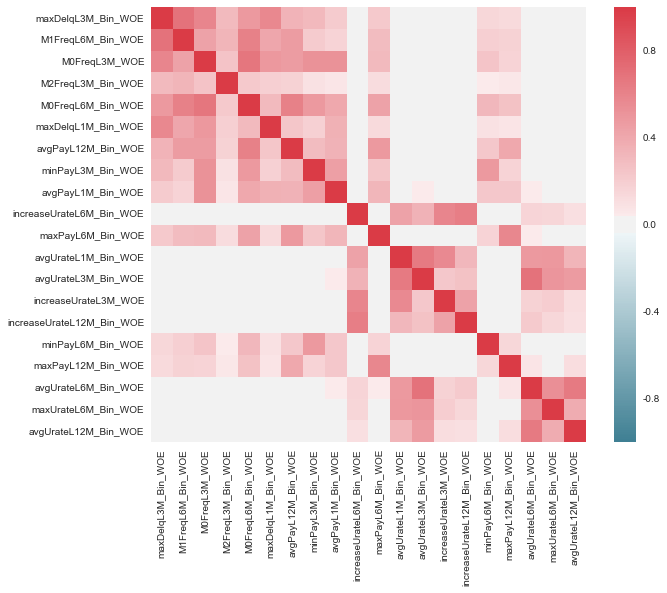

In [11]:
##############################
#   3, 单变量分析和多变量分析   #
##############################
#  选取IV高于0.02的变量
high_IV = [(k,v['IV']) for k,v in WOE_IV_dict.items() if v['IV'] >= 0.02]
high_IV_sorted = sorted(high_IV, key=lambda k: k[1],reverse=True)
for (var,iv) in high_IV:
    newVar = var+"_WOE"
    trainData[newVar] = trainData[var].map(lambda x: WOE_IV_dict[var]['WOE'][x])
'''
多变量分析：比较两两线性相关性。如果相关系数的绝对值高于阈值，剔除IV较低的一个
'''
deleted_index = []
cnt_vars = len(high_IV_sorted)
for i in range(cnt_vars):
    if i in deleted_index:
        continue
    x1 = high_IV_sorted[i][0]+"_WOE"
    for j in range(cnt_vars):
        if i == j or j in deleted_index:
            continue
        y1 = high_IV_sorted[j][0]+"_WOE"
        roh = np.corrcoef(trainData[x1],trainData[y1])[0,1]
        if abs(roh)>0.7:
            x1_IV = high_IV_sorted[i][1]
            y1_IV = high_IV_sorted[j][1]
            if x1_IV > y1_IV:
                deleted_index.append(j)
            else:
                deleted_index.append(i)

single_analysis_vars = [high_IV_sorted[i][0]+"_WOE" for i in range(cnt_vars) if i not in deleted_index]


X = trainData[single_analysis_vars]
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)

In [12]:
'''
多变量分析：VIF
'''
X = np.matrix(trainData[single_analysis_vars])
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print (max(VIF_list))
# 最大的VIF是 3.429，小于10，因此这一步认为没有多重共线性
multi_analysis = single_analysis_vars

3.42877127102


In [13]:
################################
#   4, 建立逻辑回归模型预测违约   #
################################
X = trainData[multi_analysis]
X['intercept'] = [1] * X.shape[0]
y = trainData['label']
logit = sm.Logit(y, X)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
fit_result = fit_result.sort_values(by = 'coef')
print(fit_result)

Optimization terminated successfully.
         Current function value: 0.257556
         Iterations 7
                               coef        p-value
intercept                 -1.816283   0.000000e+00
increaseUrateL6M_Bin_WOE  -1.173992   1.903327e-51
maxDelqL3M_Bin_WOE        -0.743386  9.651350e-168
M2FreqL3M_Bin_WOE         -0.681728   6.707808e-64
avgUrateL1M_Bin_WOE       -0.661764   1.130685e-11
avgUrateL3M_Bin_WOE       -0.526255   2.215594e-06
M0FreqL3M_WOE             -0.457005   4.802085e-39
avgUrateL6M_Bin_WOE       -0.194809   2.415588e-01
M1FreqL6M_Bin_WOE         -0.152977   2.393983e-05
maxDelqL1M_Bin_WOE        -0.139531   3.646633e-06
maxPayL6M_Bin_WOE         -0.136920   4.660105e-02
maxUrateL6M_Bin_WOE       -0.123916   3.453710e-01
avgPayL12M_Bin_WOE        -0.085567   6.952669e-02
increaseUrateL12M_Bin_WOE -0.038580   7.057984e-01
maxPayL12M_Bin_WOE        -0.023687   8.302923e-01
increaseUrateL3M_WOE       0.001685   9.871766e-01
minPayL6M_Bin_WOE          0.10

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
print(sm.Logit(y, trainData['increaseUrateL3M_WOE']).fit().params)  
print(sm.Logit(y, trainData['minPayL6M_Bin_WOE']).fit().params)  
print(sm.Logit(y, trainData['avgUrateL12M_Bin_WOE']).fit().params) 
print(sm.Logit(y, trainData['minPayL1M_Bin_WOE']).fit().params)  
print(sm.Logit(y, trainData['M0FreqL6M_Bin_WOE']).fit().params)  
print(sm.Logit(y, trainData['minPayL3M_Bin_WOE']).fit().params)  

Optimization terminated successfully.
         Current function value: 0.682128
         Iterations 4
increaseUrateL3M_WOE   -0.995312
dtype: float64
Optimization terminated successfully.
         Current function value: 0.686302
         Iterations 5
minPayL6M_Bin_WOE   -0.807779
dtype: float64
Optimization terminated successfully.
         Current function value: 0.690373
         Iterations 4
avgUrateL12M_Bin_WOE   -1.0179
dtype: float64
Optimization terminated successfully.
         Current function value: 0.671181
         Iterations 4
minPayL1M_Bin_WOE   -0.969236
dtype: float64
Optimization terminated successfully.
         Current function value: 0.613547
         Iterations 5
M0FreqL6M_Bin_WOE   -1.032842
dtype: float64
Optimization terminated successfully.
         Current function value: 0.663533
         Iterations 5
minPayL3M_Bin_WOE   -0.829298
dtype: float64


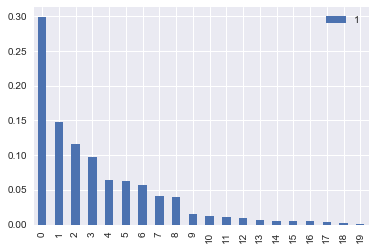

In [15]:
clf = ensemble.GradientBoostingClassifier()
gbdt_model = clf.fit(X, y)
importace = gbdt_model.feature_importances_.tolist()
featureImportance = zip(multi_analysis,importace)
featureImportanceSorted = sorted(featureImportance, key=lambda k: k[1],reverse=True)
pd.DataFrame(featureImportanceSorted).plot(kind='bar')

In [16]:
# 先假定模型可以容纳4个特征，再逐步增加特征个数，直到有特征的系数为正，或者p值超过0.1
n = 4
featureSelected = [i[0] for i in featureImportanceSorted[:n]]
X_train = X[featureSelected+['intercept']]
logit = sm.Logit(y, X_train)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
'''
                              coef       p-value
maxDelqL3M_Bin_WOE       -0.895654  0.000000e+00
increaseUrateL6M_Bin_WOE -1.084713  1.623441e-84
M0FreqL3M_WOE            -0.436273  1.556517e-74
avgUrateL1M_Bin_WOE      -0.629355  7.146665e-16
avgUrateL3M_Bin_WOE      -0.570670  8.207241e-12
intercept                -1.831752  0.000000e+00
'''
while(n<len(featureImportanceSorted)):
    nextVar = featureImportanceSorted[n][0]
    featureSelected = featureSelected + [nextVar]
    X_train = X[featureSelected+['intercept']]
    logit = sm.Logit(y, X_train)
    logit_result = logit.fit()
    params = logit_result.params
    print ("current var is ",nextVar,'   ', params[nextVar])
    if max(params) < 0:
        n += 1
    else:
        featureSelected.remove(nextVar)
        n += 1

X_train = X[featureSelected+['intercept']]
logit = sm.Logit(y, X_train)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
fit_result = fit_result.sort_values(by  = 'p-value')
print(fit_result)

Optimization terminated successfully.
         Current function value: 0.273129
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.272291
         Iterations 7
current var is  avgUrateL3M_Bin_WOE     -0.570669864576
Optimization terminated successfully.
         Current function value: 0.259249
         Iterations 7
current var is  M2FreqL3M_Bin_WOE     -0.697697001715
Optimization terminated successfully.
         Current function value: 0.258923
         Iterations 7
current var is  M1FreqL6M_Bin_WOE     -0.132593288868
Optimization terminated successfully.
         Current function value: 0.258479
         Iterations 7
current var is  maxDelqL1M_Bin_WOE     -0.134164350605
Optimization terminated successfully.
         Current function value: 0.258448
         Iterations 7
current var is  maxUrateL6M_Bin_WOE     -0.167140951473
Optimization terminated successfully.
         Current function value: 0.258444
         Iterations 7
current var

In [17]:
X2 = X[featureSelected+['intercept']]
for alpha in range(100,0,-1):
    l1_logit = sm.Logit.fit_regularized(sm.Logit(y, X2), start_params=None, method='l1', alpha=alpha)
    pvalues = l1_logit.pvalues
    params = l1_logit.params
    if max(pvalues)>=0.1 or max(params)>0:
        break

bestAlpha = alpha + 1
l1_logit = sm.Logit.fit_regularized(sm.Logit(y, X2), start_params=None, method='l1', alpha=bestAlpha)
params = l1_logit.params
params2 = params.to_dict()
featuresInModel = [k for k, v in params2.items() if k!='intercept' and v < -0.0000001]
print(featuresInModel)

X_train = X[featuresInModel + ['intercept']]
logit = sm.Logit(y, X_train)
logit_result = logit.fit()
trainData['pred'] = logit_result.predict(X_train)

ks = scorecard_function.KS(trainData, 'pred', 'label')
auc = roc_auc_score(trainData['label'],trainData['pred'])  #AUC = 0.73
#{'AUC': 0.83644931044825688, 'KS': 0.59816049348012412}
print(ks, auc)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.279090910648
            Iterations: 79
            Function evaluations: 79
            Gradient evaluations: 79
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.278901609505
            Iterations: 80
            Function evaluations: 80
            Gradient evaluations: 80
Optimization terminated successfully.    (Exit mode 0)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)



            Current function value: 0.278711995387
            Iterations: 79
            Function evaluations: 80
            Gradient evaluations: 79
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.278522067587
            Iterations: 80
            Function evaluations: 80
            Gradient evaluations: 80
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.278331825366
            Iterations: 80
            Function evaluations: 80
            Gradient evaluations: 80
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.278141267966
            Iterations: 80
            Function evaluations: 81
            Gradient evaluations: 80
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.277950394712
            Iterations: 81
            Function evaluations: 82
            Gradient evaluations: 81
Optimization termin

In [19]:
featuresInModel

['maxDelqL3M_Bin_WOE',
 'increaseUrateL6M_Bin_WOE',
 'M0FreqL3M_WOE',
 'avgUrateL1M_Bin_WOE',
 'avgUrateL3M_Bin_WOE',
 'M2FreqL3M_Bin_WOE',
 'M1FreqL6M_Bin_WOE',
 'maxDelqL1M_Bin_WOE']

In [18]:
##################################
#   5，在测试集上测试逻辑回归的结果   #
###################################
# 准备WOE编码后的变量
modelFeatures = [i.replace('_Bin','').replace('_WOE','') for i in featuresInModel]

numFeatures = [i for i in modelFeatures if i in numericalFeatures]
charFeatures = [i for i in modelFeatures if i in categoricalFeatures]

#
testData['maxDelqL1M'] = testData.apply(lambda x: DelqFeatures(x,1,'max delq'),axis=1)
testData['maxDelqL3M'] = testData.apply(lambda x: DelqFeatures(x,3,'max delq'),axis=1)
# testData['M2FreqL3M'] = testData.apply(lambda x: DelqFeatures(x, 3, 'M2 times'), axis=1)
testData['M0FreqL3M'] = testData.apply(lambda x: DelqFeatures(x,3,'M0 times'),axis=1)
testData['M1FreqL6M'] = testData.apply(lambda x: DelqFeatures(x, 6, 'M1 times'), axis=1)
testData['M2FreqL3M'] = testData.apply(lambda x: DelqFeatures(x, 3, 'M2 times'), axis=1)
# testData['M1FreqL12M'] = testData.apply(lambda x: DelqFeatures(x, 12, 'M1 times'), axis=1)
# testData['maxUrateL6M'] = testData.apply(lambda x: UrateFeatures(x,6,'max utilization rate'),axis = 1)
testData['avgUrateL1M'] = testData.apply(lambda x: UrateFeatures(x,1, 'mean utilization rate'),axis=1)
testData['avgUrateL3M'] = testData.apply(lambda x: UrateFeatures(x,3, 'mean utilization rate'),axis=1)
# testData['avgUrateL6M'] = testData.apply(lambda x: UrateFeatures(x,6, 'mean utilization rate'),axis=1)
testData['increaseUrateL6M'] = testData.apply(lambda x: UrateFeatures(x, 6, 'increase utilization rate'),axis=1)
# testData['avgPayL3M'] = testData.apply(lambda x: PaymentFeatures(x, 3, 'mean payment ratio'),axis=1)
# testData['avgPayL6M'] = testData.apply(lambda x: PaymentFeatures(x, 6, 'mean payment ratio'),axis=1)
#
testData['M2FreqL3M_Bin'] = testData['M2FreqL3M'].apply(lambda x: int(x>=1))
testData['maxDelqL1M_Bin'] = testData['maxDelqL1M'].apply(lambda x: scorecard_function.MergeByCondition(x, ['==0', '==1', '>=2']))
testData['maxDelqL3M_Bin'] = testData['maxDelqL3M'].apply(lambda x: scorecard_function.MergeByCondition(x, ['==0', '==1', '>=2']))
for var in numFeatures:
        newBin = var+"_Bin"
        bin = list([i.values() for i in bin_dict if var in i][0])[0]
        testData[newBin] = testData[var].apply(lambda x: scorecard_function.AssignBin(x, bin))

finalFeatures = [i+'_Bin' for i in numFeatures] + ['M2FreqL3M_Bin','maxDelqL1M_Bin','maxDelqL3M_Bin','M0FreqL3M']
for var in finalFeatures:
    var2 = var+"_WOE"
    testData[var2] = testData[var].apply(lambda x: WOE_IV_dict[var]['WOE'][x])

X_test = testData[featuresInModel]
X_test['intercept'] = [1]*X_test.shape[0]
testData['pred'] = logit_result.predict(X_test)


ks = scorecard_function.KS(testData, 'pred', 'label')
auc = roc_auc_score(testData['label'],testData['pred'])
print(ks, auc)

0.649478597889 0.844320886699


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


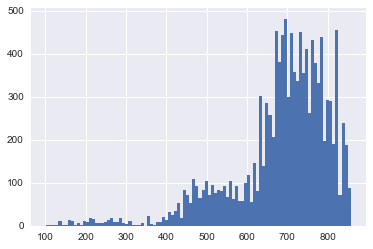

In [19]:
##########################
#   6，在测试集上计算分数   #
##########################
BasePoint, PDO = 500,50
testData['score'] = testData['pred'].apply(lambda x: scorecard_function.Prob2Score(x, BasePoint, PDO))
plt.hist(testData['score'],bins=100)
plt.show()